In [1]:
import math

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight

import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

from data_manipulation.reading_util import load_non_enz_esm2
from collections import Counter
from data_manipulation.reading_util import load_all_sub_classes
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score

load_dotenv()


2023-10-21 11:19:07.708400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 11:19:07.929098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 11:19:07.931671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 11:19:09.314726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

![Image of Split30](/home/malte/Desktop/Dataset/plots/class_count_comparison/SPLIT30.png)

In [2]:
emb_path = os.getenv("ESM2_ENZYMES_SPLIT_30")
csv_path = os.getenv("CSV30_ENZYMES")
wanted_ec = 1

# Extracting 2nd ec class form wanted main class
----

### Critical 2nd ec classes

| Class | Count |
|-------|-------|
| 1.10  | 10    |
| 1.20  | 8     |
| 1.23  | 2     |
| 1.97  | 7     |
| 2.2   | 19    |
| 2.9   | 5     | 
| 2.10  | 2     |
| 3.3   | 18    |
| 3.7   | 14    |
| 3.8   | 8     |
| 3.9   | 1     |
| 3.11  | 1     |
| 3.13  | 1     |
| 4.5   | 1     |
| 4.7   | 1     |
| 5.5   | 18    |
| 5.99  | 1     |
| 6.4   | 11    |
| 6.6   | 6     |
| 7.3   | 9     |
| 7.4   | 9     |
| 7.5   | 4     |
| 7.6   | 13    |
  
----


In [3]:
# all possible sub classes in split 30
ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 18,
    "1.23": 19,
    "1.97": 20,
    "2.1": 21,
    "2.3": 22,
    "2.4": 23,
    "2.5": 24,
    "2.6": 25,
    "2.7": 26,
    "2.8": 27,
    "2.2": 28,
    "2.9": 29,
   "2.10": 30,
    "3.1": 31,
    "3.2": 32,
    "3.4": 33,
    "3.5": 34,
    "3.6": 35,
    "3.3": 36,
    "3.7": 37,
    "3.8": 38,
    "3.9": 39,
   "3.11": 40,
   "3.13": 41,
    "4.1": 42,
    "4.2": 43,
    "4.3": 44,
    "4.4": 45,
    "4.6": 46,
   "4.99": 47,
    "4.7": 48,
    "4.5": 49,
    "5.1": 50,
    "5.2": 51,
    "5.3": 52,
    "5.4": 53,
    "5.5": 54,
    "5.6": 55,
    "5.7": 56,
   "5.99": 57,
    "6.1": 58,
    "6.2": 59,
    "6.3": 60,
    "6.5": 61,
    "6.4": 62,
    "6.6": 63,
    "7.1": 64,
    "7.2": 65,
    "7.3": 66,
    "7.4": 67,
    "7.5": 68,
    "7.6": 69,
}

# Compressed 2nd subclasses when # samples in subclass < 20
comp_ec_to_label = { 
    "1.1": 0,
    "1.2": 1, 
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}


comp_label_to_ec = {
 0: "1.1" ,
 1: "1.2" ,
 2: "1.3" ,
 3: "1.4" ,
 4: "1.5" ,
 5: "1.6" ,
 6: "1.7" ,
 7: "1.8" ,
 8: "1.11" ,
 9: "1.12" ,
 10: "1.13" ,
 11: "1.14" ,
 12: "1.15" ,
 13: "1.16" ,
 14: "1.17" ,
 15: "1.18" ,
 16: "1.21" ,
 17: "1.10_20_23_97" ,
 18: "2.1" ,
 19: "2.3" ,
 20: "2.4" ,
 21: "2.5" ,
 22: "2.6" ,
 23: "2.7" ,
 24: "2.8" ,
 25: "2.2_9_19" ,
 26: "3.1" ,
 27: "3.2" ,
 28: "3.4" ,
 29: "3.5" ,
 30: "3.6" ,
 31: "3.3_7_8_9_11_13" ,
 32: "4.1" ,
 33: "4.2" ,
 34: "4.3" ,
 35: "4.4" ,
 36: "4.6" ,
 37: "4.99_7_5" ,
 38: "5.1" ,
 39: "5.2" ,
 40: "5.3" ,
 41: "5.4" ,
 42: "5.5" ,
 43: "5.6_7_99" ,
 44: "6.1" ,
 45: "6.2" ,
 46: "6.3" ,
 47: "6.5_4_6" ,
 48: "7.1" ,
 49: "7.2" ,
 50: "7.3_4_5_6" ,
}


In [4]:
print(len(comp_ec_to_label))
print(len(ec_to_label))

70
70


In [35]:
X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)




LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.047 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204


In [36]:
# y_encoded = tf.keras.utils.to_categorical(y, num_classes=len(label_to_ec))

# oversample = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# X_train_dup = np.vstack((X_train, X_train))
# y_train_dup = np.hstack((y_train, y_train))

# y_train_dup_encoded = tf.keras.utils.to_categorical(y_train_dup, num_classes=len(label_to_ec))

# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_ec))

In [37]:
print(len(X_train))
print(len(y_train))

6442
6442


In [38]:
print(max(y))

50


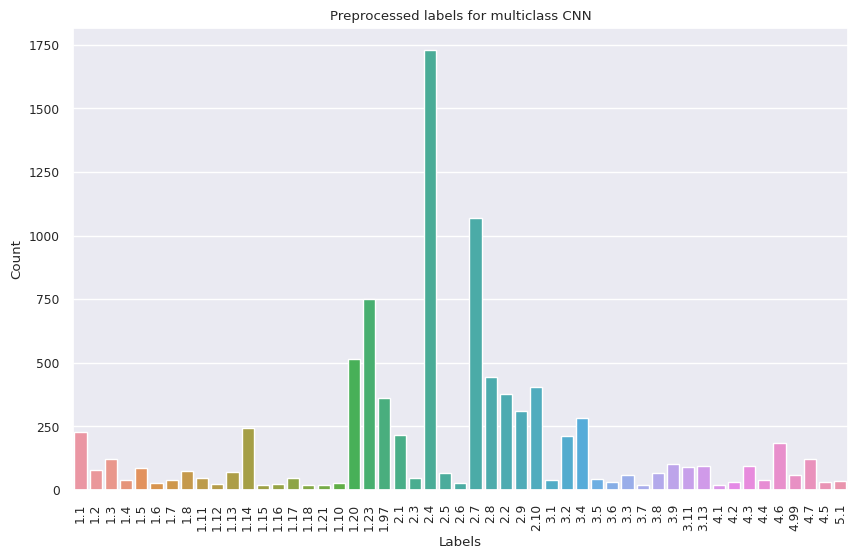

In [39]:
y_sorted = y.copy()
y_sorted.sort()

y_ec_classes = [label_to_ec[label] for label in y_sorted]
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set(font_scale=0.8)  # Adjust font size as needed

countplot = sns.countplot(x=y_ec_classes)
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

# Add labels and title
plt.title("Preprocessed labels for multiclass CNN")
plt.xlabel("Labels")
plt.ylabel("Count")

# Show the plot
plt.show()

# Training a CNN based on amount of y_labels
----

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(sec_to_label))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(sec_to_label))


# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_ec))



In [11]:
print(y_test_encoded[0])
print(len(X_train))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
12885


# Optimizing with Optuna
----

In [27]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 182)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=len(label_to_ec), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_ec))

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=40, callbacks=[early_stop], verbose=0)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # You can adjust the number of trials as needed

[I 2023-10-18 20:28:27,124] A new study created in memory with name: no-name-f2e44fec-64dc-455a-af5d-f754acaf78b8
[I 2023-10-18 20:30:29,195] Trial 0 finished with value: 0.9739974141120911 and parameters: {'num_units_dense_1': 405, 'dropout_rate_1': 0.6951358355462809, 'num_units_dense_2': 190, 'dropout_rate_2': 0.19350988730285842, 'num_units_dense_3': 24}. Best is trial 0 with value: 0.9739974141120911.
[I 2023-10-18 20:31:00,031] Trial 1 finished with value: 1.0509899854660034 and parameters: {'num_units_dense_1': 81, 'dropout_rate_1': 0.29772099176579586, 'num_units_dense_2': 68, 'dropout_rate_2': 0.29603169024714504, 'num_units_dense_3': 84}. Best is trial 0 with value: 0.9739974141120911.
[I 2023-10-18 20:32:10,227] Trial 2 finished with value: 1.1090517044067383 and parameters: {'num_units_dense_1': 391, 'dropout_rate_1': 0.024720166533678943, 'num_units_dense_2': 120, 'dropout_rate_2': 0.6828591209005634, 'num_units_dense_3': 161}. Best is trial 0 with value: 0.973997414112091

In [42]:
# v3 best
# best_params = study.best_params
best_params = {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

# v1 best params
# best_params = {'num_units_dense_1': 386, 'dropout_rate_1': 0.4179955867912854, 'num_units_dense_2': 187, 'dropout_rate_2': 0.28289383930137707, 'num_units_dense_3': 54} 
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']
best_dropout_rate_2 = best_params['dropout_rate_2']
best_num_units_dense_3 = best_params['num_units_dense_3']


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# prev b
# best_num_units_dense_1 = 482
# best_dropout_rate_1 = 0.6974068495461625
# best_num_units_dense_2 = 277
# best_dropout_rate_2 = 0.04421161571807377
# best_num_units_dense_3 = 127

# v4 {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))

final_model.add(tf.keras.layers.Dense(units=len(label_to_ec), activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=15)

final_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=250, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)


Epoch 1/250
202/202 [==============================] - 5s 20ms/step - loss: 4.0631 - accuracy: 0.0151 - val_loss: 3.9562 - val_accuracy: 0.0199
Epoch 2/250
202/202 [==============================] - 4s 19ms/step - loss: 3.8887 - accuracy: 0.0213 - val_loss: 3.8296 - val_accuracy: 0.0221
Epoch 3/250
202/202 [==============================] - 4s 19ms/step - loss: 3.6939 - accuracy: 0.0371 - val_loss: 3.7352 - val_accuracy: 0.0453
Epoch 4/250
202/202 [==============================] - 4s 19ms/step - loss: 3.4142 - accuracy: 0.0669 - val_loss: 3.2776 - val_accuracy: 0.1322
Epoch 5/250
202/202 [==============================] - 4s 19ms/step - loss: 3.0970 - accuracy: 0.0976 - val_loss: 2.8878 - val_accuracy: 0.1901
Epoch 6/250
202/202 [==============================] - 4s 19ms/step - loss: 2.8913 - accuracy: 0.1312 - val_loss: 2.9254 - val_accuracy: 0.1854
Epoch 7/250
202/202 [==============================] - 4s 19ms/step - loss: 2.6756 - accuracy: 0.1527 - val_loss: 2.5829 - val_accuracy:

In [44]:
# Initializing the model
# model = tf.keras.models.Sequential()
# 
# earl_stop = tf.keras.callbacks.EarlyStopping(patience=3)
# 
# # Adding input layer
# model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
# 
# # Adding hidden layer
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# 
# # Finally adding output layer using softmax as activation function
# model.add(tf.keras.layers.Dense(units=len(sec_to_label), activation='softmax'))  # Using softmax for multi-class classification
# 
# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam')


In [45]:
# model.fit(x=X_train, y=y_train_encoded, epochs=30, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

<Figure size 1000x600 with 0 Axes>

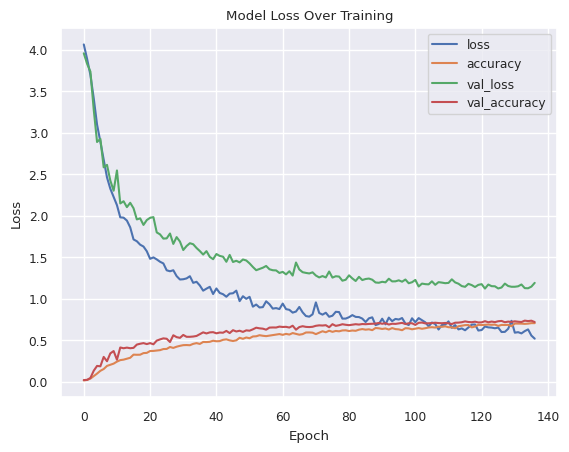

In [43]:
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [44]:
predictions = np.argmax(final_model.predict(X_test), axis=-1) 

87/87 [==============================] - 0s 3ms/step


In [45]:

report = classification_report(y_test, predictions, zero_division=0)
print(report)


              precision    recall  f1-score   support

           0       0.68      0.74      0.71        68
           1       0.78      0.78      0.78        18
           2       0.66      0.75      0.70        36
           3       0.13      0.33      0.19         6
           4       0.60      0.53      0.56        34
           5       0.50      0.71      0.59         7
           6       0.75      0.43      0.55        14
           7       0.67      0.61      0.64        23
           8       0.69      0.64      0.67        14
           9       0.36      0.57      0.44         7
          10       0.60      0.71      0.65        21
          11       0.84      0.82      0.83        74
          12       0.67      1.00      0.80         2
          13       1.00      0.78      0.88         9
          14       0.89      0.53      0.67        15
          15       0.29      0.67      0.40         3
          16       0.33      0.29      0.31         7
          17       0.33    

In [53]:
def plot_report(report, y, predictions, save_path, dpi=300):
    """
    Plots results of model
    :param report: Report of model
    """
    metrics = [] 
    class_labels = list(comp_label_to_ec.values())
    class_output = []
    for i in range(2, len(report.split("\n"))-5):
        class_output.append(report.split('\n')[i].split()[0])
        metrics.append(report.split('\n')[i].split()[1:])

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        if len(class_m) != 0:
            precision = float(class_m[0])
            recall = float(class_m[1])
            f1_score = float(class_m[2])
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)
        else:
            precision = 0
            recall = 0
            f1_score = 0
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)


    # Plot accuracy for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, recs)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("Recall")
    plt.xlabel("2nd EC Class")
    plt.tight_layout()
    
    
    if save_path:
        plt.savefig(f"{save_path}acc.png", dpi=dpi)
    else:
        plt.show()


    # Plot precision for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, precs)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("Precision")
    plt.xlabel("2nd EC Class")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}weighted_prec.png", dpi=dpi)
    else:
        plt.show()


    # Plot F1 score for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, f1_s)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("F1 Score")
    plt.xlabel("2nd EC Class")

    # Adjust layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}weighted_f1.png", dpi=dpi)
    else:
        plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=0.5)  # Adjust font size as needed
    
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    # heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=15)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.title("Confusion Matrix")
    
    if save_path:
        plt.savefig(f"{save_path}weighted_conf.png", dpi=dpi)
    else:
        plt.show()



In [54]:
print(len(report.split("\n")))

58


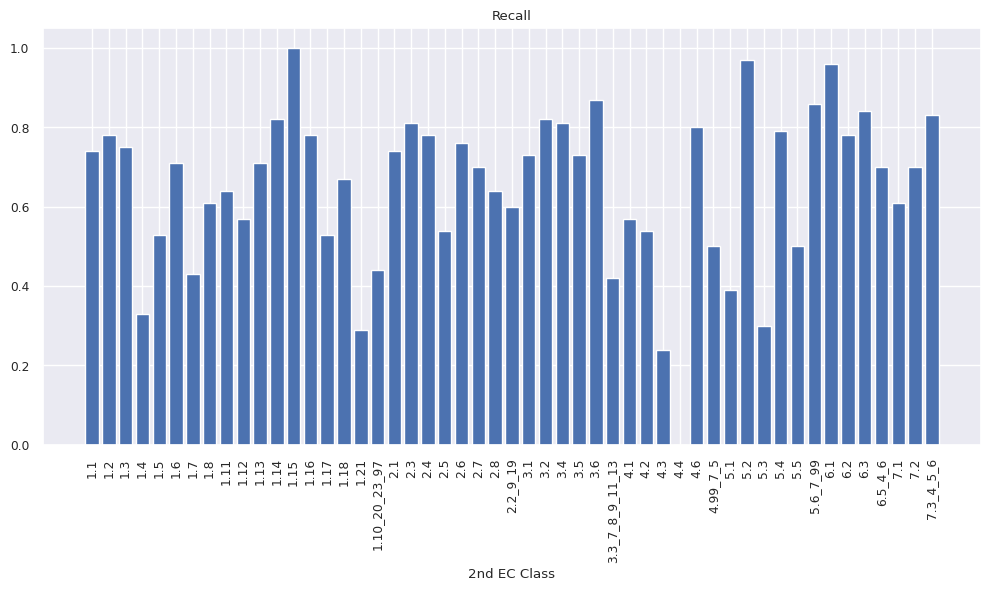

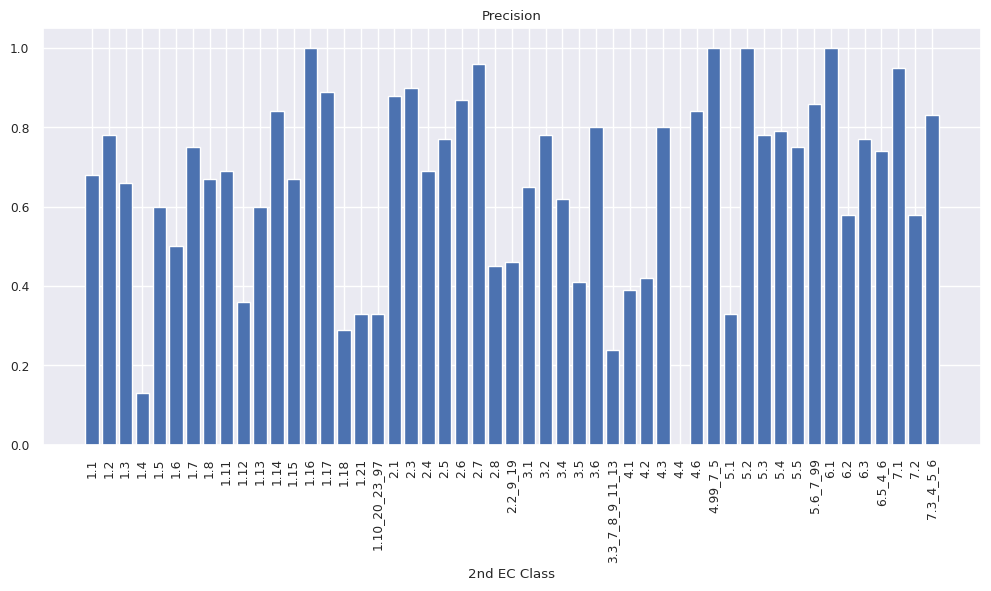

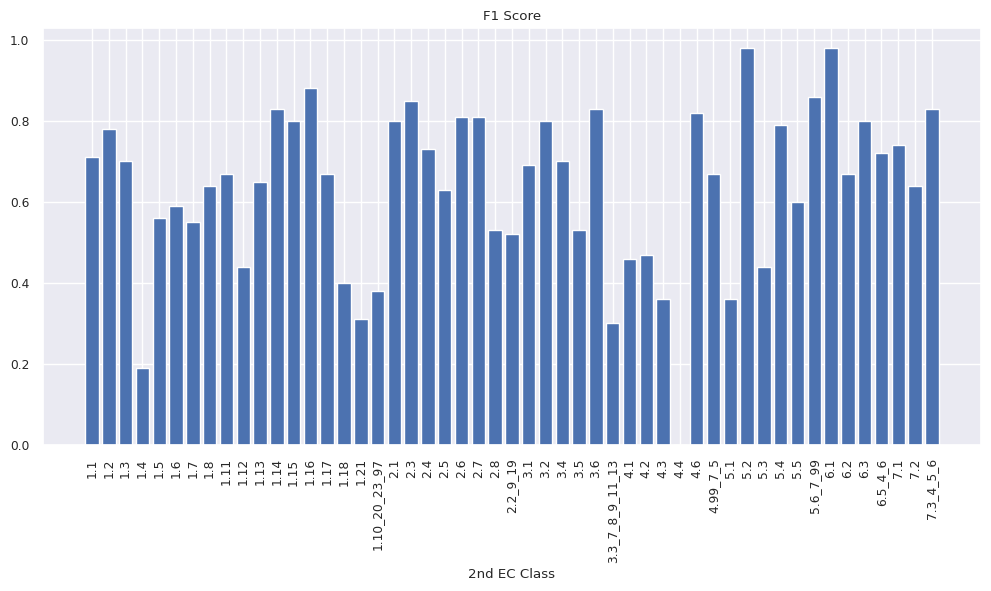

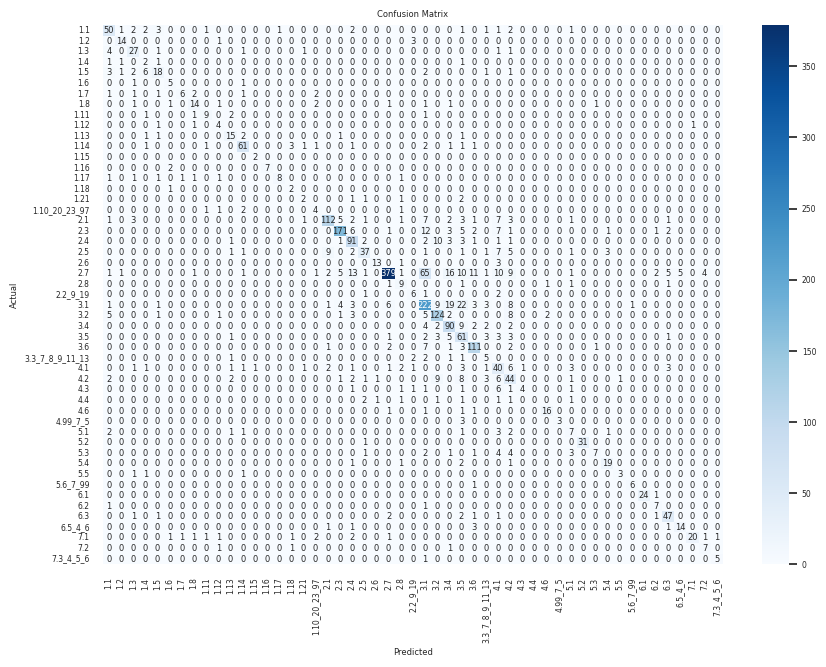

In [55]:
plot_report(report=report, y=y_test, predictions=predictions, save_path="/home/malte/Desktop/Multiclass_CNN/",
            dpi=700)

In [47]:
tf.keras.models.save_model(final_model, "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_v1.keras")



In [68]:

class_labels = list(label_to_ec.values())

conf_matrix = confusion_matrix(y_test, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [5]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_v1.keras")

emb_path = os.getenv("ESM2_ENZYMES_SPLIT_30")
csv_path = os.getenv("CSV30_ENZYMES")

X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

predictions = np.argmax(model.predict(X_test), axis=-1)

counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))



LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.161 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204
87/87 [==============================] - 0s 3ms/step
Correct predictions:  1985
Total samples predicted: 2762


In [6]:
print(label_to_ec)

# Correct predictions:  2236
# Total samples predicted: 2762

{0: '1.1', 1: '1.2', 2: '1.3', 3: '1.4', 4: '1.5', 5: '1.6', 6: '1.7', 7: '1.8', 8: '1.11', 9: '1.12', 10: '1.13', 11: '1.14', 12: '1.15', 13: '1.16', 14: '1.17', 15: '1.18', 16: '1.21', 17: '1.10', 18: '1.20', 19: '1.23', 20: '1.97', 21: '2.1', 22: '2.3', 23: '2.4', 24: '2.5', 25: '2.6', 26: '2.7', 27: '2.8', 28: '2.2', 29: '2.9', 30: '2.10', 31: '3.1', 32: '3.2', 33: '3.4', 34: '3.5', 35: '3.6', 36: '3.3', 37: '3.7', 38: '3.8', 39: '3.9', 40: '3.11', 41: '3.13', 42: '4.1', 43: '4.2', 44: '4.3', 45: '4.4', 46: '4.6', 47: '4.99', 48: '4.7', 49: '4.5', 50: '5.1', 51: '5.2', 52: '5.3', 53: '5.4', 54: '5.5', 55: '5.6', 56: '5.7', 57: '5.99', 58: '6.1', 59: '6.2', 60: '6.3', 61: '6.5', 62: '6.4', 63: '6.6', 64: '7.1', 65: '7.2', 66: '7.3', 67: '7.4', 68: '7.5', 69: '7.6'}


In [7]:

mcc = matthews_corrcoef(y_test, predictions)
print("MCC Score:", mcc)


MCC Score: 0.7003044791679208


In [63]:
print(class_weights)

# Create a confusion matrix based on predictions and true labels
conf_matrix = confusion_matrix(y_test, predictions)

# Apply class weights to the confusion matrix
weighted_confusion_matrix = conf_matrix * class_weights[:, np.newaxis]

# Calculate the sum of squares for the weighted confusion matrix
sum_of_squares = np.sum(weighted_confusion_matrix ** 2)

# Calculate the weighted MCC
weighted_mcc = sum_of_squares / np.sqrt(np.prod(class_weights) * np.sum(conf_matrix))

print('Weighted MCC:', weighted_mcc)

NameError: name 'class_weights_dict' is not defined

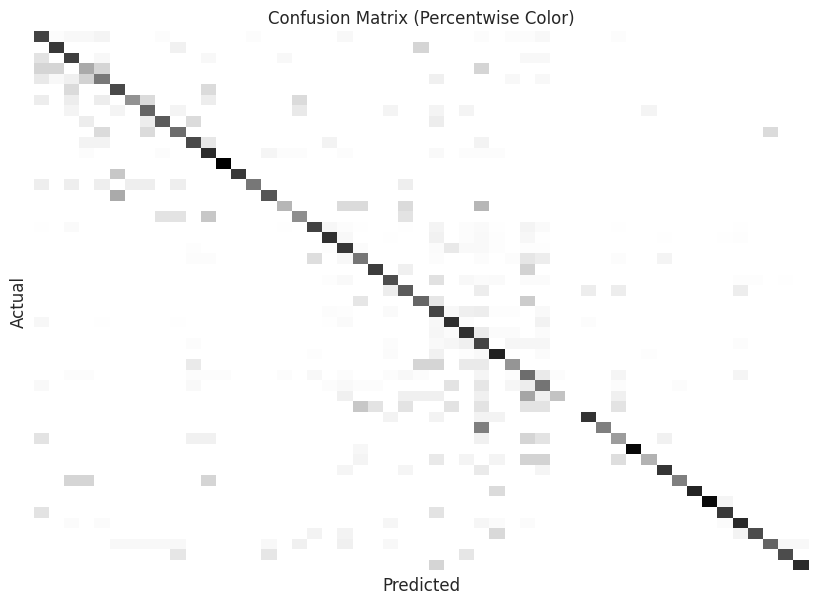

In [71]:
class_labels = list(label_to_ec.values())

conf_matrix = confusion_matrix(y_test, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()


# Calculate standard error

In [24]:
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)
    
    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.66
    max_value = 0.77

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    plt.title('Close-up Distribution Plot')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)

In [25]:
def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)

In [26]:
def train_and_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

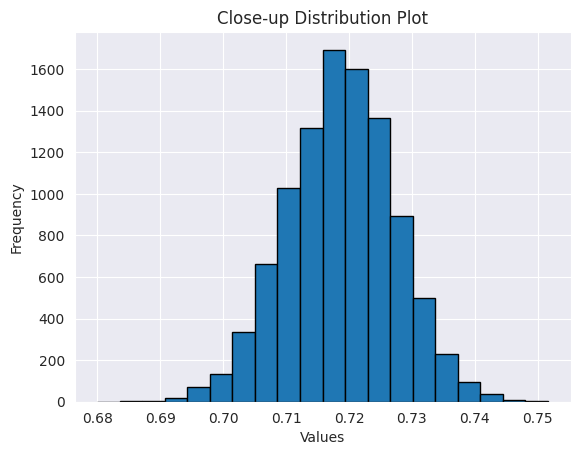

Multiclass CNN:
  - Initial F1 Score: 0.72
  - Mean ± SE: 0.719 ± 0.0085
  - 95% CI: [0.70, 0.74]


In [27]:
initial_f1 = calculate_f1(y_test, predictions)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, predictions, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")